In [133]:
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
import qibo
from tqdm import tqdm
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import L_BFGS_B, SPSA
from qiskit.primitives import Estimator
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit import QuantumCircuit
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError, pauli_error, depolarizing_error, thermal_relaxation_error)
from qiskit_nature.second_q.mappers import ParityMapper
from qibo import models, gates, hamiltonians
from qibo.noise import IBMQNoiseModel

In [134]:
qibo.set_backend("numpy")

[Qibo 0.2.11|INFO|2024-08-23 13:32:11]: Using numpy backend on /CPU:0


In [135]:
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.725",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

es_problem = driver.run()

In [136]:
mapper = ParityMapper(num_particles=es_problem.num_particles)

In [137]:
print("Hamiltonian of Molecule:")
hamiltonian = es_problem.hamiltonian.second_q_op()
qubit_op = mapper.map(hamiltonian)
aux_op = mapper.map(es_problem.second_q_ops()[1])
for pauli, coeff in sorted(qubit_op.label_iter()):
    print(f"{coeff.real:+.8f} * {pauli}")

Hamiltonian of Molecule:
-1.05016043 * II
+0.40421466 * IZ
+0.18037525 * XX
-0.40421466 * ZI
-0.01134688 * ZZ


In [173]:
ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
    ),
)

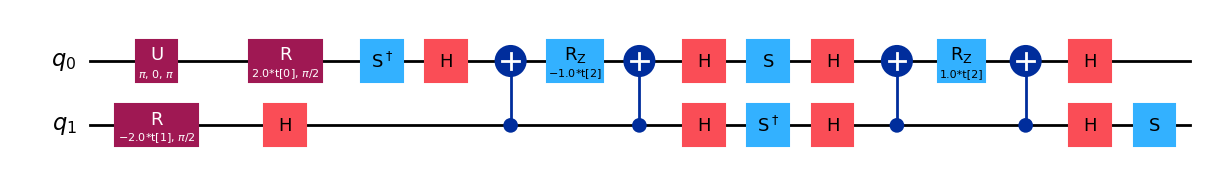

In [174]:
ansatz.decompose(reps=3).draw(output="mpl")

In [175]:
hamil = hamiltonians.Hamiltonian(qubit_op.num_qubits, qubit_op.to_matrix())

In [188]:
def convert(qc):
    qibo_circuit = models.Circuit(qc.num_qubits, density_matrix=True)
    for instruction, qargs, cargs in qc:
        if instruction.name == 'h':
            qibo_circuit.add(gates.H(qargs[0]._index))
        elif instruction.name == 'x':
            qibo_circuit.add(gates.X(qargs[0]._index))
        elif instruction.name == 'cx':
            qibo_circuit.add(gates.CNOT(qargs[0]._index, qargs[1]._index))
        elif instruction.name == 'ccx':
            qibo_circuit.add(gates.TOFFOLI(qargs[0]._index, qargs[1]._index, qargs[2]._index))
        elif instruction.name == 'rx':
            qibo_circuit.add(gates.RX(qargs[0]._index, theta=instruction.params[0]))
        elif instruction.name == 'ry':
            qibo_circuit.add(gates.RY(qargs[0]._index, theta=instruction.params[0]))
        elif instruction.name == 'rz':
            qibo_circuit.add(gates.RZ(qargs[0]._index, theta=instruction.params[0]))
        elif instruction.name == 'u':
            qibo_circuit.add(gates.U3(qargs[0]._index, theta=instruction.params[0], phi=instruction.params[1], lam=instruction.params[2], trainable=False))
        elif instruction.name == 's':
            qibo_circuit.add(gates.S(qargs[0]._index))
        elif instruction.name == 'sdg':
            qibo_circuit.add(gates.SDG(qargs[0]._index))
        elif instruction.name == 'r':
            qibo_circuit.add(gates.U1(qargs[0]._index, theta=instruction.params[0]))
        elif instruction.name == 'measure':
            # Qibo handles measurements during execution
            pass
        else:
            raise NotImplementedError(f"Gate {instruction.name} is not implemented in this conversion.")
    return qibo_circuit

In [189]:
circuit = convert(ansatz.decompose(reps=3))
circuit.get_parameters()

[(ParameterExpression(2.0*t[0]),),
 (ParameterExpression(-2.0*t[1]),),
 (ParameterExpression(-1.0*t[2]),),
 (ParameterExpression(1.0*t[2]),)]

In [171]:
nqubits = 2
nlayers  = 1

# Create variational circuit
circuit = models.Circuit(nqubits, density_matrix=True)
for l in range(nlayers):
    circuit.add((gates.RY(q, theta=0) for q in range(nqubits)))
    circuit.add((gates.CZ(q, q+1) for q in range(0, nqubits-1, 2)))
    circuit.add((gates.RY(q, theta=0) for q in range(nqubits)))
    circuit.add((gates.CZ(q, q+1) for q in range(1, nqubits-2, 2)))
    circuit.add(gates.CZ(0, nqubits-1))
circuit.add((gates.RY(q, theta=0) for q in range(nqubits)))

In [172]:
circuit.draw()

'q0: ─RY─o─RY─o─RY─\nq1: ─RY─Z─RY─Z─RY─'

In [186]:
parameters = {
    "t1": 10e-6,
    "t2": 5e-6,
    "gate_times" : (40*1e-9, 150*1e-9),
    "excited_population" : 0,
    "depolarizing_one_qubit" : 0,
    "depolarizing_two_qubit": 0,
    "readout_one_qubit" : {"0": 0, "1": 0},
}

noise_model = IBMQNoiseModel()
noise_model.from_dict(parameters)
noisy_circuit = noise_model.apply(circuit)

In [150]:
qaoa = models.QAOA(hamil)
initial_parameters = 0.01 * np.random.uniform(0,1,4)
best_energy, final_parameters, extra = qaoa.minimize(initial_parameters, method="parallel_L-BFGS-B")

In [187]:
vqe = models.VQE(noisy_circuit, hamil)
initial_parameters = [0.0] * 4
initial_parameters = np.random.uniform(0, 2*np.pi,
                                        2*nqubits*nlayers + nqubits)
best, params, extra = vqe.minimize(initial_parameters, method='parallel_L-BFGS-B', compile=False)

TypeError: object of type 'numpy.float64' has no len()

In [165]:
calculated = best + es_problem.hamiltonian.constants['nuclear_repulsion_energy']
actual = es_problem.reference_energy
print("Total Calculated Energy:", calculated)
print("Actual Energy:", actual)
print(f"Percentage Error: {(calculated - actual) / calculated * 100:.2f}%")

Total Calculated Energy: -0.928068525732901
Actual Energy: -0.6148699740425608
Percentage Error: 33.75%


In [166]:
distances = np.hstack((np.arange(0.2, 1.55, 0.05), np.arange(1.75, 4.25, 0.25)))
vqe_energies = []

for distance in tqdm(distances, desc="Calculating energies"):
    driver = PySCFDriver(
        atom=f"H 0 0 0; H 0 0 {distance}",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    es_problem = driver.run()
    qubit_op, aux_op = es_problem.second_q_ops()
    qubit_op, aux_op = mapper.map(qubit_op), mapper.map(aux_op)
    hamil = hamiltonians.Hamiltonian(qubit_op.num_qubits, qubit_op.to_matrix())
    vqe = models.VQE(noisy_circuit, hamil)
    initial_parameters = np.random.uniform(0, 2*np.pi,
                                            2*nqubits*nlayers + nqubits)
    best, params, extra = vqe.minimize(initial_parameters, method='parallel_L-BFGS-B', compile=False)
    calculated = best + es_problem.hamiltonian.constants['nuclear_repulsion_energy']
    vqe_energies.append(calculated)

Calculating energies: 100%|██████████| 37/37 [00:47<00:00,  1.28s/it]


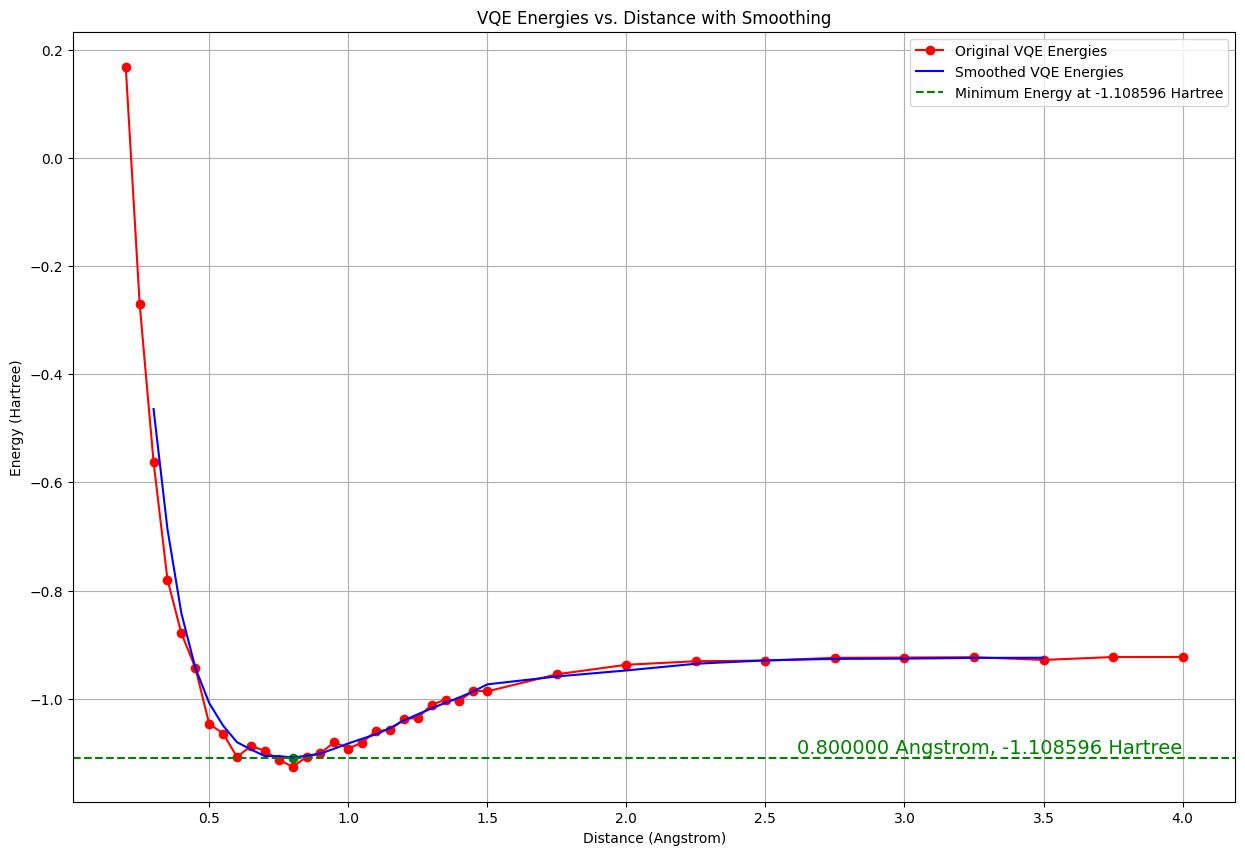

The minimum energy is -1.108596 Hartree at a distance of 0.800000 Angstrom


In [167]:
kernel_size = 5
kernel = np.ones(kernel_size) / kernel_size

# Apply convolution to smooth the energies
smoothed_energies = np.convolve(vqe_energies, kernel, mode='valid')

# Adjust distances to match the length of the smoothed energies
adjusted_distances = distances[(kernel_size-1)//2:-(kernel_size-1)//2] if kernel_size % 2 != 0 else distances[(kernel_size)//2:-(kernel_size)//2]

# Find the minimum energy and corresponding distance
min_energy = smoothed_energies.min()
min_energy_distance = adjusted_distances[smoothed_energies.argmin()]

# Plot the original and smoothed energies
plt.figure(figsize=(15, 10))
plt.plot(distances, vqe_energies, 'o-', label='Original VQE Energies', color='red')
plt.plot(adjusted_distances, smoothed_energies, '-', label='Smoothed VQE Energies', color='blue')

# Draw a horizontal line at the minimum energy point
plt.axhline(min_energy, color='green', linestyle='--', label=f'Minimum Energy at {min_energy:.6f} Hartree')
plt.scatter(min_energy_distance, min_energy, color='green')  # Mark the minimum point
plt.text(distances[-1], min_energy, f'{min_energy_distance:.6f} Angstrom, {min_energy:.6f} Hartree', color='green', fontsize=14, ha='right', va='bottom')


plt.xlabel('Distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('VQE Energies vs. Distance with Smoothing')
plt.legend()
plt.grid(True)
plt.show()

print(f"The minimum energy is {min_energy:.6f} Hartree at a distance of {min_energy_distance:.6f} Angstrom")

In [23]:
class EnergyCalculator:
    def __init__(self, acc):
        parameters = {
            "t1": acc * 1e-6,
            "t2": acc * 0.5e-6,
            "gate_times" : (40*1e-9, 150*1e-9),
            "excited_population" : 0,
            "depolarizing_one_qubit" : 0,
            "depolarizing_two_qubit": 0,
            "readout_one_qubit" : {"0": 0, "1": 0},
        }
        
        noise_model = IBMQNoiseModel()
        noise_model.from_dict(parameters)
        self.noisy_circuit = noise_model.apply(circuit)
        self.vqe_energies = []

    def calculate(self):
        self.vqe_energies = []
        for distance in distances:
            driver = PySCFDriver(
                atom=f"H 0 0 0; H 0 0 {distance}",
                basis="sto3g",
                charge=0,
                spin=0,
                unit=DistanceUnit.ANGSTROM,
            )
            es_problem = driver.run()
            qubit_op, aux_op = es_problem.second_q_ops()
            qubit_op, aux_op = mapper.map(qubit_op), mapper.map(aux_op)
            hamil = hamiltonians.Hamiltonian(qubit_op.num_qubits, qubit_op.to_matrix())
            vqe = models.VQE(self.noisy_circuit, hamil)
            initial_parameters = [0.0] * 4
            best, params, extra = vqe.minimize(initial_parameters, method='parallel_L-BFGS-B', compile=False)
            calculated = best + es_problem.hamiltonian.constants['nuclear_repulsion_energy']
            self.vqe_energies.append(calculated)

    def minimum(self):
        kernel_size = 5
        kernel = np.ones(kernel_size) / kernel_size
        smoothed_energies = np.convolve(self.vqe_energies, kernel, mode='valid')
        adjusted_distances = distances[(kernel_size-1)//2:-(kernel_size-1)//2] if kernel_size % 2 != 0 else distances[kernel_size // 2:-kernel_size // 2]
        return smoothed_energies.min(), adjusted_distances[smoothed_energies.argmin()]

In [26]:
distances = np.arange(0.70, 1.15, 0.05)
accuracies = np.arange(1, 101, 1)

results = []
for accuracy in tqdm(accuracies, desc="Evaluating simulation"):
    calculator = EnergyCalculator(accuracy)
    calculator.calculate()
    results.append(calculator.minimum())

energies = []
min_dist = []
for result in results:
    energies.append(result[0].item())
    min_dist.append(result[1].item())

Evaluating simulation: 100%|██████████| 100/100 [08:19<00:00,  4.99s/it]


In [32]:
import pandas as pd
df = pd.DataFrame()
df[f"energy1"] = energies
df.to_csv("energy_acc_qibo.csv", index=False)

In [33]:
from scipy.optimize import curve_fit

def func(x, a, b, c, p):
  return (a * np.exp(-b * x)) / np.sqrt(x + c) + p

params, _ = curve_fit(func, accuracies, energies, p0=(1, 1, 1, 0), bounds=([-5] * 4, [5] * 4), maxfev=10000)
a, b, c, p = params
y_fit = func(np.arange(1, 101, 1), *params)
print(*params)

0.6120664330694529 0.040044251744258234 0.249493501866921 -1.1123652739544987


In [34]:
from sklearn.metrics import r2_score
actual = -1.117506
r2_score(energies, y_fit)

0.9987656671649777

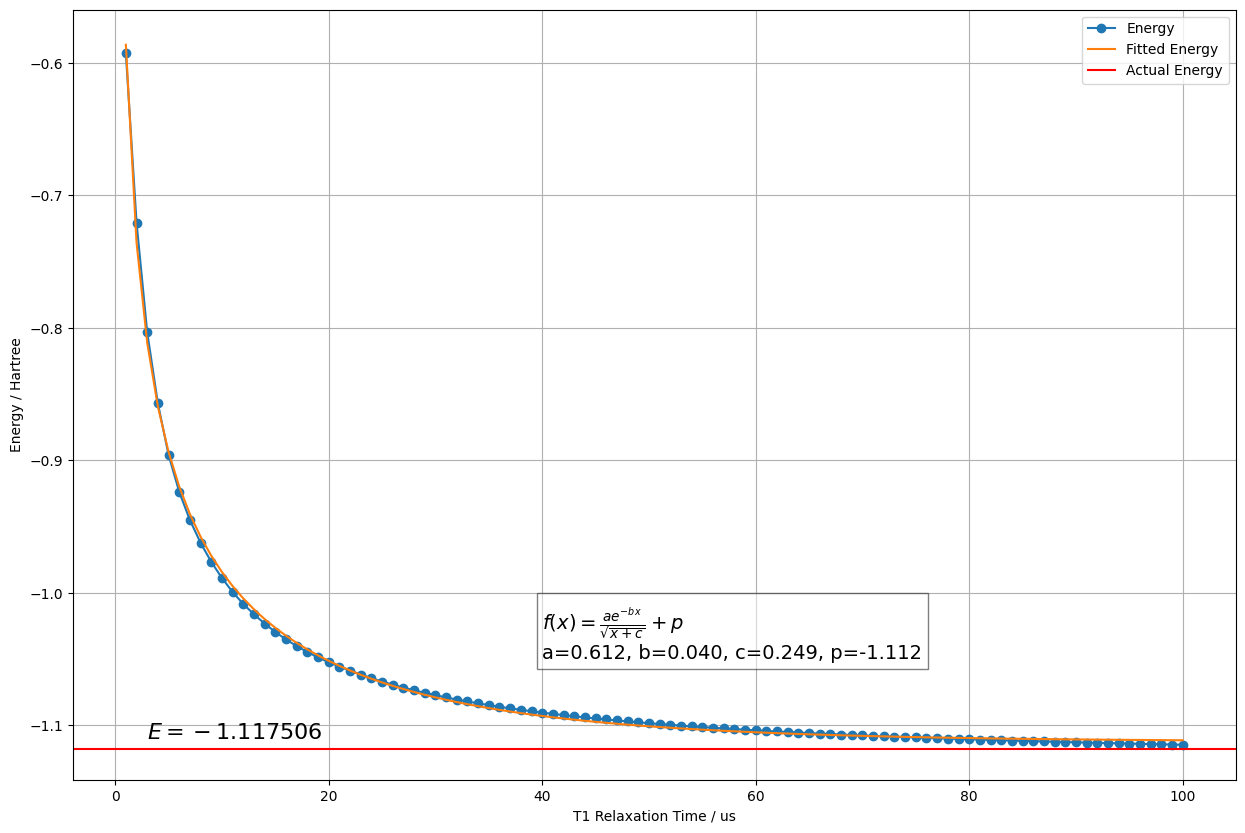

In [35]:
plt.figure(figsize=(15, 10))
plt.style.use('fast')
plt.plot(accuracies, energies, 'o-', label="Energy")
plt.plot(accuracies, y_fit, label="Fitted Energy")
equation_text = r'$f(x) = \frac{{ae^{{-bx}}}}{{\sqrt{{x + c}}}} + p$'
params_text = f'a={a:.3f}, b={b:.3f}, c={c:.3f}, p={p:.3f}'
plt.text(40, -1.05, equation_text + '\n' + params_text, fontsize=14, bbox=dict(facecolor='white', alpha=0.5))
plt.text(3, -1.11, r'$E = -1.117506$', fontsize=16)
plt.axhline(y=actual, color='r', label="Actual Energy")
plt.xlabel('T1 Relaxation Time / us')
plt.ylabel('Energy / Hartree')
plt.grid(True)
plt.legend()
plt.show()

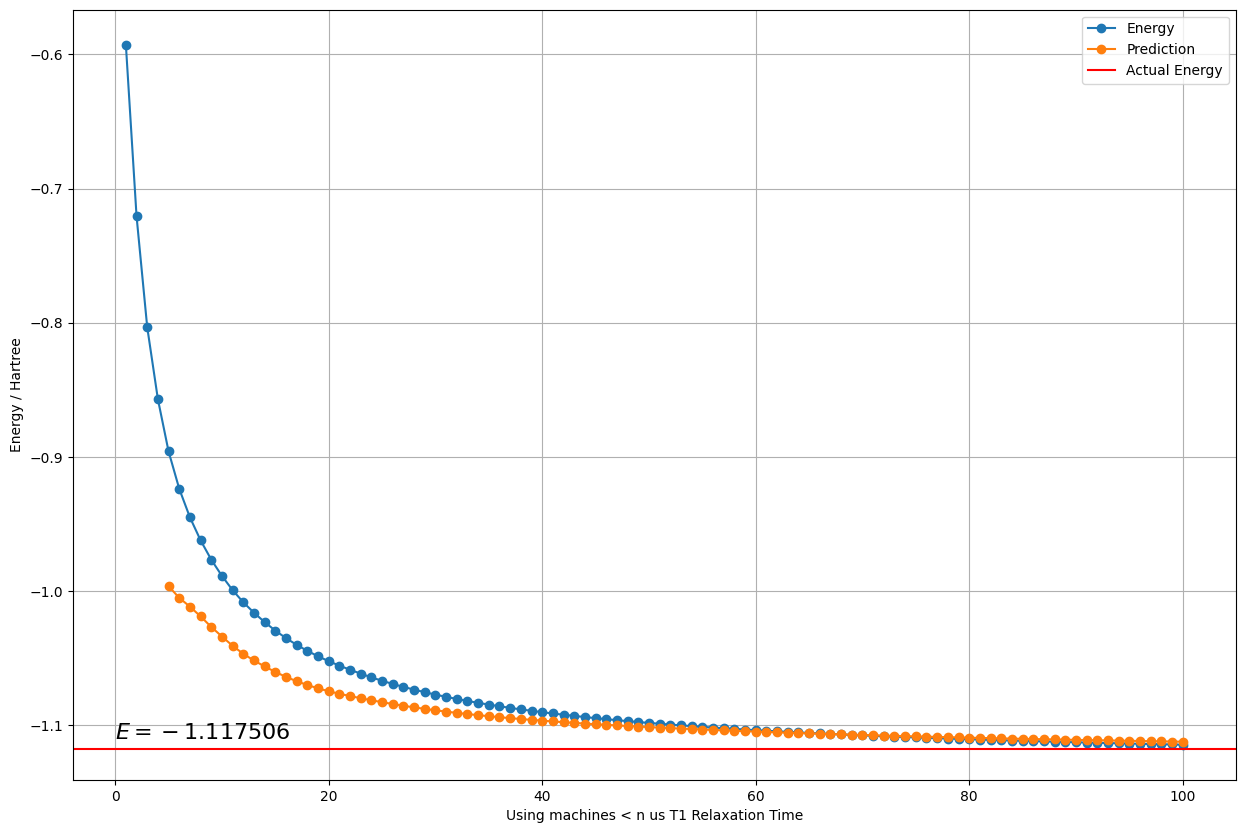

In [36]:
guesses = []
for limit in range(5, 101):
  params, _ = curve_fit(func, accuracies[:limit], energies[:limit],
                        p0=(1, 1, 1, 0), bounds=([-5] * 4, [5] * 4), maxfev=10000)
  a, b, c, p = params
  guesses.append(p)

guesses = np.array(guesses)
plt.figure(figsize=(15, 10))
plt.style.use('fast')
plt.plot(accuracies, energies, 'o-', label="Energy")
plt.text(0, -1.11, r'$E = -1.117506$', fontsize=16)
plt.plot(np.arange(5, 101, 1), guesses, 'o-', label="Prediction")
plt.axhline(y=actual, color='r', label="Actual Energy")
plt.xlabel('Using machines < n us T1 Relaxation Time')
plt.ylabel('Energy / Hartree')
plt.grid(True)
plt.legend()
plt.show()